#Comment this block if you are NOT using colabVM

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

In [1]:
#UNCOMMENT IF USING CADE
import os
##### Request a GPU #####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 3500):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader        
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        
## Request a gpu and reserve the memory space
define_gpu_to_use(4000)

Chosen GPU: 0


# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [2]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from cs6353.classifiers.cnn import *
from cs6353.data_utils import get_CIFAR10_data
from cs6353.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs6353.layers import *
from cs6353.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# # for auto-reloading external modules
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `cs6353/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [4]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))


Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs6353/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [5]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.37264006649648e-11


# Max-Pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs6353/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)


correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max-Pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs6353/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [7]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. As proposed in the original paper [3], batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.


[3] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

In the file `cs6353/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [8]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [9]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-7.69687344e-15 -6.68606584e-15 -5.13021864e-15 -1.09345193e-14]
  stds:  [0.99999898 0.9999991  0.99999909 0.99999904]


## Spatial batch normalization: backward
In the file `cs6353/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [10]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648201640115e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


# Group Normalization
In the previous notebook, we mentioned that Layer Normalization is an alternative normalization technique that mitigates the batch size limitations of Batch Normalization. However, as the authors of [4] observed, Layer Normalization does not perform as well as Batch Normalization when used with Convolutional Layers:

>With fully connected layers, all the hidden units in a layer tend to make similar contributions to the final prediction, and re-centering and rescaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of the hidden units whose
receptive fields lie near the boundary of the image are rarely turned on and thus have very different
statistics from the rest of the hidden units within the same layer.

The authors of [5] propose an intermediary technique. In contrast to Layer Normalization, where you normalize over the entire feature per-datapoint, they suggest a consistent splitting of each per-datapoint feature into G groups, and a per-group per-datapoint normalization instead. 

![Comparison of normalization techniques discussed so far](normalization.png)
<center>**Visual comparison of the normalization techniques discussed so far (image edited from [5])**</center>

Even though an assumption of equal contribution is still being made within each group, the authors hypothesize that this is not as problematic, as innate grouping arises within features for visual recognition. One example they use to illustrate this is that many high-performance handcrafted features in traditional Computer Vision have terms that are explicitly grouped together. Take for example Histogram of Oriented Gradients [6]-- after computing histograms per spatially local block, each per-block histogram is normalized before being concatenated together to form the final feature vector.

You will now implement Group Normalization. Note that this normalization technique that you are to implement in the following cells was introduced and published to arXiv *less than a month ago* -- this truly is still an ongoing and excitingly active field of research!

[4] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)


[5] [Wu, Yuxin, and Kaiming He. "Group Normalization." arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)


[6] [N. Dalal and B. Triggs. Histograms of oriented gradients for
human detection. In Computer Vision and Pattern Recognition
(CVPR), 2005.](https://ieeexplore.ieee.org/abstract/document/1467360/)

## Spatial Group normalization: forward

In the file `cs6353/layers.py`, implement the forward pass for group normalization in the function `spatial_groupnorm_forward`. Check your implementation by running the following:

In [11]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x_g.mean(axis=1))
print('  Stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out_g.mean(axis=1))
print('  Stds: ', out_g.std(axis=1))

Before spatial group normalization:
  Shape:  (2, 6, 4, 5)
  Means:  [9.72505327 8.51114185 8.9147544  9.43448077]
  Stds:  [3.67070958 3.09892597 4.27043622 3.97521327]
After spatial group normalization:
  Shape:  (1, 1, 1, 2, 6, 4, 5)
  Means:  [-2.14643118e-16  5.25505565e-16  2.58126853e-16 -3.62672855e-16]
  Stds:  [0.99999963 0.99999948 0.99999973 0.99999968]


## Spatial group normalization: backward
In the file `cs6353/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_groupnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [12]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)
#You should expect errors of magnitudes between 1e-12~1e-07
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  6.34590431845254e-08
dgamma error:  1.0546047434202244e-11
dbeta error:  3.810857316122484e-12


# ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs6353/classifiers/cnn.py` and complete the implementation of the `ConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [13]:
# num_inputs = 2
# input_dim = (3, 16, 16)
# reg = 0.0
# num_classes = 10
# np.random.seed(231)
# X = np.random.randn(num_inputs, *input_dim)
# y = np.random.randint(num_classes, size=num_inputs)

# model = ThreeLayerConvNet(num_filters=3, filter_size=3,
#                           input_dim=input_dim, hidden_dim=7,
#                           dtype=np.float64)
# loss, grads = model.loss(X, y)
# # Errors should be small, but correct implementations may have
# # relative errors up to the order of e-2
# for param_name in sorted(grads):
#     f = lambda _: model.loss(X, y)[0]
#     param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
#     e = rel_error(param_grad_num, grads[param_name])
#     print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))


model = ConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

# print(model.loss(X, y))

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)
print('log(10): ', np.log(10))

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3116596580092312
log(10):  2.302585092994046
Initial loss (with regularization):  2.3356916237697454


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [14]:
num_inputs = 2
input_dim = (3, 8, 8)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ConvNet(input_dim=input_dim, dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))
    # print('%s max relative error: %e' % (param_name, param_grad_num))

W_1 max relative error: 4.684024e-01
W_2 max relative error: 3.027209e-05
W_3 max relative error: 1.521006e-06
b_1 max relative error: 1.628472e-08
b_2 max relative error: 1.613293e-08
b_3 max relative error: 9.360861e-10
beta1 max relative error: 1.034391e-06
beta2 max relative error: 4.716913e-07
gamma1 max relative error: 3.499269e-06
gamma2 max relative error: 1.537313e-05


### Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in high training accuracy and comparatively low validation accuracy.

In [15]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[16, 32],
    filter_sizes=[7, 3],
    weight_scale=1e-2
)

solver = Solver(
    model, small_data,
    num_epochs=50, batch_size=20,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 1e-2,
    },
    verbose=True, print_every=10
)
solver.train()

(Iteration 1 / 250) loss: 2.735618
(Epoch 0 / 50) train acc: 0.180000; val_acc: 0.121000
(Epoch 1 / 50) train acc: 0.370000; val_acc: 0.181000
(Epoch 2 / 50) train acc: 0.410000; val_acc: 0.146000
(Iteration 11 / 250) loss: 4.138183
(Epoch 3 / 50) train acc: 0.400000; val_acc: 0.115000
(Epoch 4 / 50) train acc: 0.580000; val_acc: 0.166000
(Iteration 21 / 250) loss: 1.486943
(Epoch 5 / 50) train acc: 0.730000; val_acc: 0.209000
(Epoch 6 / 50) train acc: 0.740000; val_acc: 0.194000
(Iteration 31 / 250) loss: 0.785646
(Epoch 7 / 50) train acc: 0.800000; val_acc: 0.224000
(Epoch 8 / 50) train acc: 0.840000; val_acc: 0.200000
(Iteration 41 / 250) loss: 0.729946
(Epoch 9 / 50) train acc: 0.930000; val_acc: 0.206000
(Epoch 10 / 50) train acc: 0.930000; val_acc: 0.211000
(Iteration 51 / 250) loss: 0.055936
(Epoch 11 / 50) train acc: 0.940000; val_acc: 0.201000
(Epoch 12 / 50) train acc: 0.990000; val_acc: 0.208000
(Iteration 61 / 250) loss: 0.105686
(Epoch 13 / 50) train acc: 0.970000; val_acc

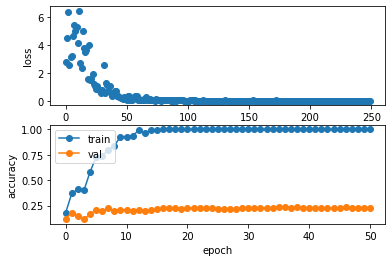

In [16]:
# Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train a good CNN.
    
By tweaking different parameters, such as number of convolution layers, learning rate, batch size, etc, you should achieve greater than 62% accuracy on the validation set **with 3 epochs using the sgd_momentum optimizer**.
    
If you are really careful, you should be able to get nearly 66% accuracy on the validation set. But we don't give extra credits for doing so.
    
It may take a quite while for your training to be finished. **Do not use more than four convolution layers. Your training shouldn't be longer than one hour.** (This is a rough reference as it depends on the hardware. Our implementation takes about 10-15 minutes to finish.)
    
Use a large filter/kernel size in the first convolution layer (for example, 7), so you can easily visualize the learend filters.
    
Since it is relatively slower to train a CNN, you can simply report the best hyper parameters you found. You need report validation accuracy of other choices below.

In [17]:
best_model = None
################################################################################
# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    #
# the sgd_momentum optimizer. Store your best model in the best_model variable.#
################################################################################

# raise NotImplementedError
model = ConvNet(
    weight_scale=0.01, 
    reg=0.000001,
    use_batch_norm=True,
    num_filters=[16, 32, 64],
    filter_sizes=[7, 7, 3]
)

solver = Solver(
    model, data,
    num_epochs=3, batch_size=32,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 5e-3, 'lr_decay': 0.98
    },
    verbose=True, print_every=50
)
solver.train()

best_model = model
best_model.params.update(solver.best_params)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################



(Iteration 1 / 4593) loss: 2.813290
(Epoch 0 / 3) train acc: 0.164000; val_acc: 0.152000
(Iteration 51 / 4593) loss: 2.896852
(Iteration 101 / 4593) loss: 2.787180
(Iteration 151 / 4593) loss: 1.895524
(Iteration 201 / 4593) loss: 1.753565
(Iteration 251 / 4593) loss: 1.627394
(Iteration 301 / 4593) loss: 1.486855
(Iteration 351 / 4593) loss: 1.639293
(Iteration 401 / 4593) loss: 1.536671
(Iteration 451 / 4593) loss: 1.355593
(Iteration 501 / 4593) loss: 1.456251
(Iteration 551 / 4593) loss: 1.632776
(Iteration 601 / 4593) loss: 1.539111
(Iteration 651 / 4593) loss: 1.255545
(Iteration 701 / 4593) loss: 1.519179
(Iteration 751 / 4593) loss: 1.575602
(Iteration 801 / 4593) loss: 1.313616
(Iteration 851 / 4593) loss: 1.671568
(Iteration 901 / 4593) loss: 1.158067
(Iteration 951 / 4593) loss: 1.283438
(Iteration 1001 / 4593) loss: 1.463887
(Iteration 1051 / 4593) loss: 1.269820
(Iteration 1101 / 4593) loss: 1.189647
(Iteration 1151 / 4593) loss: 1.138343
(Iteration 1201 / 4593) loss: 1.61

Validation set accuracy:  0.672
Test set accuracy:  0.666


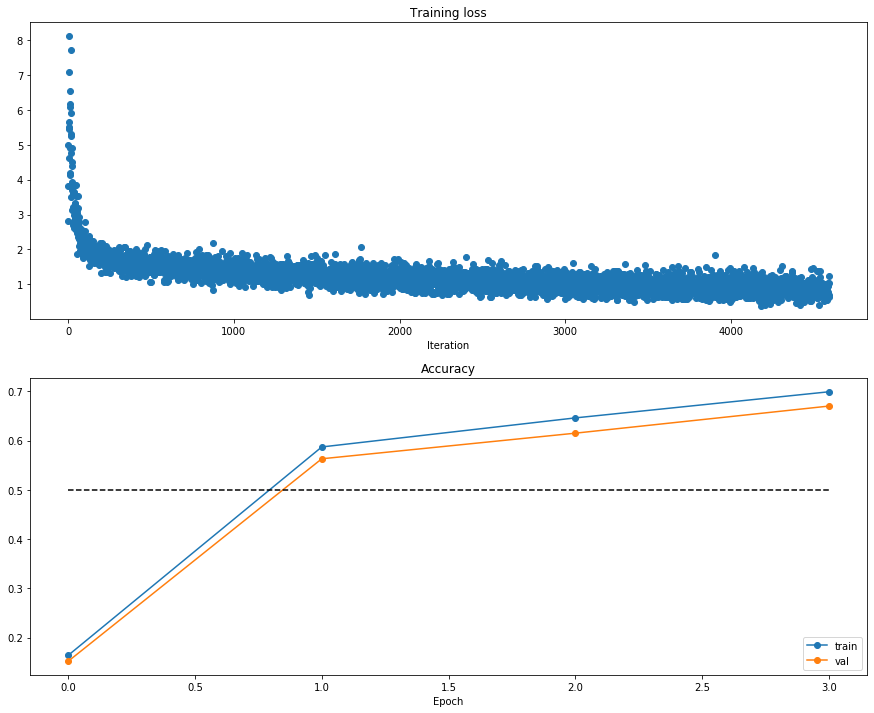

In [18]:
# Run your best model on the validation and test sets. You should achieve above 62% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())


plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

### Visualize Filters

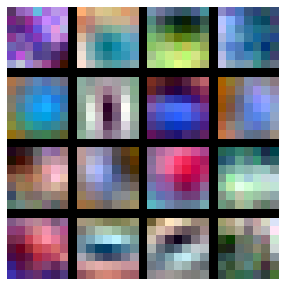

In [19]:
# You can visualize the first-layer convolutional filters from the trained network by running the following:
from cs6353.vis_utils import visualize_grid

grid = visualize_grid(model.params['W_1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

**Report validation accuray for other hyper parameters you have tried**

weight_scale=0.01, reg=0.000001,num_filters=[32, 32, 64],filter_sizes=[7, 7, 3], learning_rate = 5e-3, validation accuray = 0.18
weight_scale=0.01, reg=0.00001,num_filters=[16, 32, 64],filter_sizes=[7, 3, 3], learning_rate = 5e-3, validation accuray = 0.13

**Task 4.4: train a ConvNet without using batch normalization layers.**
    
Report the best validation accuracy you can get and discuss how it is different from the version with batch normalization layers.